In [2]:
!pip install catboost

  Using cached catboost-1.2.8-cp312-cp312-win_amd64.whl.metadata (1.5 kB)
  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
  Using cached plotly-6.5.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached narwhals-2.12.0-py3-none-any.whl.metadata (11 kB)
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.8/102.4 MB 2.1 MB/s eta 0:00:49
   ---------------------------------------- 0.8/102.4 MB 2.1 MB/s eta 0:00:49
   ---------------------------------------- 1.0/102.4 MB 1.5 MB/s eta 0:01:07
    --------------------------------------- 1.3/102.4 MB 1.4 MB/s eta 0:01:14
    --------------------------------------- 1.6/102.4 MB 1.3 MB/s eta 0:01:20
    --------------------------------------- 1.6/102.4 MB 1.3 MB/s eta 0:01:20
    --------------------------------------- 1.6/102.4 MB 1.3 MB/s eta 0:01:20
    --------------------------------------- 1.8


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")

In [25]:
df = pd.read_csv('admissions_processed.csv')

In [26]:
df.head()

,id,student_id,student_name,student_type,university_name,university_name_stripped,course_name,credential,credential_standardized,categorical_course_name,...,ug_major_bucket_Bio_Biomed_Health_LifeSci,ug_major_bucket_Business_Management_Finance,ug_major_bucket_Chemical_Materials_Petroleum,ug_major_bucket_Civil_Construction_Env_Arch,ug_major_bucket_Computer_Science_Software,ug_major_bucket_Data_Science_AI_Machine_Learning,ug_major_bucket_Electrical_Electronics_ECE,ug_major_bucket_Humanities_Social_Design_Arts,ug_major_bucket_Mechanical_Industrial_Aero,ug_major_bucket_Other
0,4c241fd2-12c7-45cb-a88f-3e45000f7fc6,1433417,Nidhi Gujar,International,"Texas A&M University, College Station",texas a&m university college station,Public Health,Masters,Masters (Technical),Bio_Biomed_Health_LifeSci,...,True,False,False,False,False,False,False,False,False,False
1,a09a96c2-1a18-4ee6-8559-127e75c1974c,1433417,Nidhi Gujar,International,Brown University,brown university,Public Health,Masters,Masters (Technical),Bio_Biomed_Health_LifeSci,...,True,False,False,False,False,False,False,False,False,False
2,5a742e81-1a10-47eb-a0b2-a650b60889fb,1433417,Nidhi Gujar,International,New York University,new york university,Public Health,Masters,Masters (Technical),Bio_Biomed_Health_LifeSci,...,True,False,False,False,False,False,False,False,False,False
3,c72a197a-2440-4d19-aad1-b1cb38b6a584,1433417,Nidhi Gujar,International,Columbia University,columbia university,Public Health,MPH,Masters (Professional),Bio_Biomed_Health_LifeSci,...,True,False,False,False,False,False,False,False,False,False
4,13c53445-952f-4f76-bf58-75ba37ae8f01,1433417,Nidhi Gujar,International,Emory University,emory university,Global Health,MPH,Masters (Professional),Bio_Biomed_Health_LifeSci,...,True,False,False,False,False,False,False,False,False,False


In [27]:
df.columns

Index(['id', 'student_id', 'student_name', 'student_type', 'university_name',
       'university_name_stripped', 'course_name', 'credential',
       'credential_standardized', 'categorical_course_name', 'target_degree',
       'application_status', 'admission_result', 'application_term',
       'application_year', 'gpa', 'gpa_scale', 'gpa_normalized', 'gpa_missing',
       'undergrad_major', 'ug_major_bucket', 'undergrad_university',
       'undergrad_canonical', 'undergrad_canonical_stripped',
       'undergrad_missing', 'toefl', 'ielts', 'english_test_normalized',
       'english_missing', 'gre_total', 'gre_verbal', 'gre_quant', 'gre_awa',
       'gre_missing', 'work_experience', 'relevant_work_experience',
       'internship_experience', 'publications', 'has_scholarship',
       'scholarship_amount', 'scholarship_currency', 'cs_rank',
       'cs_rank_missing', 'eng_rank', 'eng_rank_missing', 'mba_rank',
       'mba_rank_missing', 'gen_rank', 'gen_rank_missing', 'stripped_name',
    

In [28]:
rank_cols = ["cs_rank", "eng_rank", "mba_rank", "gen_rank"]
for col in rank_cols:
    if col in df.columns:
        # 1) Turn the 9999 sentinel back into NaN
        df[col] = df[col].replace(9999, np.nan)
        # 2) Rebuild the *_missing flag so it matches this
        df[f"{col}_missing"] = df[col].isna().astype(int)

In [30]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

In [31]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [32]:
df['cs_rank'].value_counts(dropna=False)

cs_rank
NaN      104071
94.0      14549
27.0      14133
39.0      13195
64.0      12045
80.0      10533
61.0      10366
120.0      7056
21.0       6286
54.0       5591
45.0       4830
51.0       4481
160.0      3910
16.0       3836
13.0       3016
133.0      2943
7.0        2823
35.0       2540
2.0        2400
71.0       2306
6.0        2306
148.0      2284
88.0       2160
174.0      1861
110.0      1792
198.0      1750
19.0       1574
44.0       1568
5.0        1348
186.0      1173
202.0       891
11.0        568
25.0        332
103.0       184
1.0          54
207.0        26
12.0         14
Name: count, dtype: int64

In [33]:
df[rank_cols].isna().sum()

cs_rank     104071
eng_rank    196857
mba_rank    243609
gen_rank     36590
dtype: int64

In [34]:
for col in rank_cols:
    print(col, (df[col] == 9999).sum())

cs_rank 0
eng_rank 0
mba_rank 0
gen_rank 0


In [35]:
for col in rank_cols:
    print(f"\n{col} unique values:")
    print(df[col].unique())


cs_rank unique values:
[ nan   7.  80.  39.  71.  13.  94.  64.  61.   6.  16.  27.   2.  51.
  21.  45.  35. 202.   5.  25.  19.  54. 120. 148.  11. 110.  44. 133.
 160.  88. 186. 198. 174. 103.   1.  12. 207.]

eng_rank unique values:
[ nan  37.  34. 101.  85.  94.  64.  59.  52. 117.   5.  18.  15.   7.
   4.  17.   1.  42.   2.  11.  27.  36.  47.  43.  49.  20.  31.   3.
  13.  39.  74.  57. 106.  69. 125. 168.  10.  89.  72.  12.  81. 120.
 158. 149. 136.  58. 173. 190. 166. 133.  25. 160.  26.  16. 111. 145.
  97. 163. 176. 132.]

mba_rank unique values:
[ nan  61.   6.  46.  58.  24.  18.  13.  35.  79.  15.  68.  73.  88.
  54.   2.  32.  76.  21. 115.  43.  31. 110.  66.  86.  17.  28. 100.
  34.   4.  29.  22.   9.  53.   5.  40.  11.  52.  97.  10.   1.  42.
 118.  82. 105.  65. 120.  95. 113.  85.  92.  38.  50. 108.  96.  77.]

gen_rank unique values:
[ 51.  13.  30.  24.  86.  63.  21.  46.  76. 121.  91.  98.  29.  39.
 109.  33.  10.  58.  44.  18.  73.  54. 105.  nan

In [36]:
for col in rank_cols:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

In [37]:
df[rank_cols].isna().sum()

cs_rank     0
eng_rank    0
mba_rank    0
gen_rank    0
dtype: int64

In [38]:
df['cs_rank'].value_counts(dropna=False)

cs_rank
61.0     114437
94.0      14549
27.0      14133
39.0      13195
64.0      12045
80.0      10533
120.0      7056
21.0       6286
54.0       5591
45.0       4830
51.0       4481
160.0      3910
16.0       3836
13.0       3016
133.0      2943
7.0        2823
35.0       2540
2.0        2400
6.0        2306
71.0       2306
148.0      2284
88.0       2160
174.0      1861
110.0      1792
198.0      1750
19.0       1574
44.0       1568
5.0        1348
186.0      1173
202.0       891
11.0        568
25.0        332
103.0       184
1.0          54
207.0        26
12.0         14
Name: count, dtype: int64

In [39]:
target = "admission_result"

In [40]:
drop_cols = ["id","student_id","student_name","student_type", "stripped_name","application_status","admission_result"]

In [41]:
raw_duplicates = [
    "credential", "categorical_course_name", "ug_major_bucket", "undergrad_canonical_stripped"
]

In [42]:
all_cols = df.columns.tolist()
drop_cols += [c for c in raw_duplicates if c in all_cols]

# Build final feature list
features = [c for c in all_cols if c not in drop_cols]

# optionally: remove any high-cardinality text columns you don't want to model raw:
text_cols_to_remove = [c for c in features if (df[c].dtype == "object" and df[c].nunique() > 100)]
features = [c for c in features if c not in text_cols_to_remove]

print("Using {} features".format(len(features)))
print(features[:150])

Using 75 features
['credential_standardized', 'target_degree', 'application_term', 'application_year', 'gpa_scale', 'gpa_normalized', 'gpa_missing', 'undergrad_missing', 'toefl', 'ielts', 'english_test_normalized', 'english_missing', 'gre_total', 'gre_verbal', 'gre_quant', 'gre_awa', 'gre_missing', 'work_experience', 'relevant_work_experience', 'internship_experience', 'publications', 'has_scholarship', 'scholarship_amount', 'scholarship_currency', 'cs_rank', 'cs_rank_missing', 'eng_rank', 'eng_rank_missing', 'mba_rank', 'mba_rank_missing', 'gen_rank', 'gen_rank_missing', 'major_alignment', 'gpa_category', 'english_proficiency', 'total_experience', 'experience_category', 'has_publications', 'gre_strength', 'is_fall_term', 'university_tier', 'academic_alignment_score', 'composite_academic_score', 'student_type_encoded', 'has_scholarship_encoded', 'application_term_encoded', 'credential_standardized_grouped', 'credential_standardized_Bachelors', 'credential_standardized_Doctoral', 'crede

In [43]:
X = df[features]
y = df["admission_result"]

In [44]:
from sklearn.preprocessing import LabelEncoder

label_cols = X.select_dtypes(include=['object']).columns

for col in label_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

In [45]:
X = X.fillna(0)

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [85]:
from collections import Counter

neg, pos = Counter(y_train)[0], Counter(y_train)[1]
scale_pos_weight = neg/pos

In [86]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [70]:
df['admission_result'].head()

0    0
1    1
2    1
3    0
4    1
Name: admission_result, dtype: int64

In [71]:
df['admission_result'].value_counts(dropna=False)

admission_result
1    164939
0     85856
Name: count, dtype: int64

In [72]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

pred = model.predict(X_test)
probs = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, pred))
print("F1 Score:", f1_score(y_test, pred))
print("ROC AUC:", roc_auc_score(y_test, probs))

Accuracy: 0.7546003708207899
F1 Score: 0.8049688653684661
ROC AUC: 0.8272054986074109


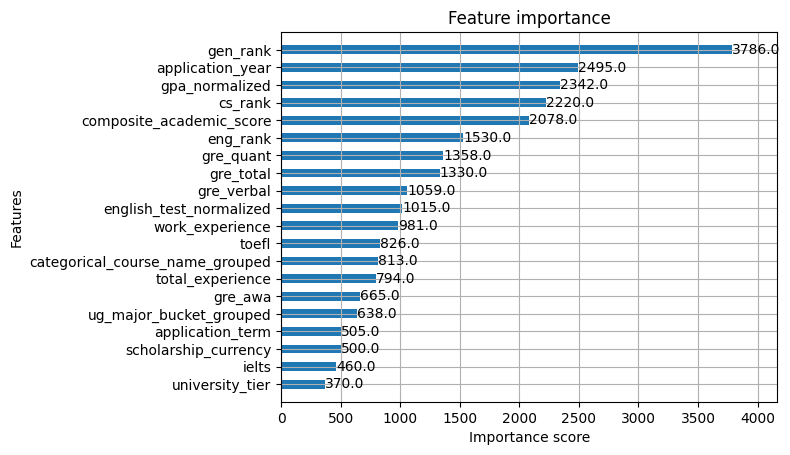

In [51]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(model, max_num_features=20, height=0.5)
plt.show()

In [52]:
import joblib
joblib.dump(model, "admission_model.pkl")
print("Model saved as admission_model.pkl")

Model saved as admission_model.pkl


In [73]:
pred = model.predict(X_test)
print(pred[:20])


[0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 1]


In [74]:
import pandas as pd

test_results = pd.DataFrame({
    "actual": y_test.values,
    "predicted": pred,
    "probability": model.predict_proba(X_test)[:, 1]
})

print(test_results.head(10))


   actual  predicted  probability
0       0          0     0.059438
1       1          1     0.586709
2       1          1     0.628709
3       1          1     0.526102
4       1          1     0.624779
5       0          0     0.268801
6       1          1     0.525180
7       1          0     0.166836
8       1          1     0.608545
9       0          0     0.121719


In [75]:
df["admission_result"].value_counts(dropna=False)

admission_result
1    164939
0     85856
Name: count, dtype: int64

In [76]:
X.isna().sum().sort_values(ascending=False).head(20)

credential_standardized     0
target_degree               0
application_term            0
application_year            0
gpa_scale                   0
gpa_normalized              0
gpa_missing                 0
undergrad_missing           0
toefl                       0
ielts                       0
english_test_normalized     0
english_missing             0
gre_total                   0
gre_verbal                  0
gre_quant                   0
gre_awa                     0
gre_missing                 0
work_experience             0
relevant_work_experience    0
internship_experience       0
dtype: int64

In [57]:
X.dtypes

credential_standardized                               int64
target_degree                                         int64
application_term                                      int64
application_year                                      int64
gpa_scale                                           float64
                                                     ...   
ug_major_bucket_Data_Science_AI_Machine_Learning       bool
ug_major_bucket_Electrical_Electronics_ECE             bool
ug_major_bucket_Humanities_Social_Design_Arts          bool
ug_major_bucket_Mechanical_Industrial_Aero             bool
ug_major_bucket_Other                                  bool
Length: 75, dtype: object

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

probs = model.predict_proba(X_test)[:,1]
print("AUC:", roc_auc_score(y_test, probs))

              precision    recall  f1-score   support

           0       0.62      0.72      0.67     17171
           1       0.84      0.77      0.80     32988

    accuracy                           0.75     50159
   macro avg       0.73      0.75      0.74     50159
weighted avg       0.77      0.75      0.76     50159

AUC: 0.8272054986074109


In [83]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [84]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    class_weight="balanced"   # improves F1
)
rf.fit(X_train, y_train)

,n_estimators,400
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [88]:
stack = StackingClassifier(
    estimators=[
        ("xgb", model),
        ("rf", rf)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    stack_method="predict_proba"
)

stack.fit(X_train, y_train)


,estimators,"[('xgb', ...), ('rf', ...)]"
,final_estimator,LogisticRegre...max_iter=1000)
,cv,None
,stack_method,'predict_proba'
,n_jobs,None
,passthrough,False
,verbose,0
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None


In [89]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = stack.predict(X_test)
y_proba = stack.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.73      0.61      0.66     17171
           1       0.81      0.88      0.84     32988

    accuracy                           0.79     50159
   macro avg       0.77      0.74      0.75     50159
weighted avg       0.78      0.79      0.78     50159

ROC-AUC: 0.8434339871134253
